In [1]:
import sys, os
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from lib.nn import *

In [2]:
transform = transforms.Compose([
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # transforms.RandomPerspective(),
    transforms.ToTensor(),
])

In [3]:
train_dataset = torchvision.datasets.CIFAR10(
    root='../../data',
    train=True,
    # transform=transform,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root='../../data',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

print(type(train_dataset.data), train_dataset.data.shape)
print(type(train_dataset.targets), len(train_dataset.targets))

Files already downloaded and verified
Files already downloaded and verified
<class 'numpy.ndarray'> (50000, 32, 32, 3)
<class 'list'> 50000


In [4]:
K = len(set(train_dataset.targets))
print("Number of classes:", K)

Number of classes: 10


In [5]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [6]:
class CNN(nn.Module):
    dense_input_size = 128 * 3 * 3

    def __init__(self, K):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2)

        self.fc1 = nn.Linear(self.dense_input_size, 1024)
        self.fc2 = nn.Linear(1024, K)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = F.relu(self.conv3(X))

        X = X.view(-1, self.dense_input_size)
        X = F.dropout(X, p=0.3)
        X = self.fc1(X)
        X = F.relu(X)
        X = F.dropout(X, p=0.3)
        X = self.fc2(X)

        return X

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CNN(K)
model.to(device)

print(device)

cuda:0


In [8]:
critrion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
train_losses, test_losses = batch_gd(
    model, critrion, optimizer, train_loader, test_loader, 15, device
)

Epoch 1/15, Train Loss: 2.0846, Test Loss: 1.9375, Duration: 0:00:09.247666
Epoch 2/15, Train Loss: 1.7988, Test Loss: 1.6829, Duration: 0:00:08.546463
Epoch 3/15, Train Loss: 1.6511, Test Loss: 1.5816, Duration: 0:00:08.328900
Epoch 4/15, Train Loss: 1.5590, Test Loss: 1.5252, Duration: 0:00:08.661959
Epoch 5/15, Train Loss: 1.4972, Test Loss: 1.4666, Duration: 0:00:08.503306
Epoch 6/15, Train Loss: 1.4513, Test Loss: 1.4420, Duration: 0:00:08.576144
Epoch 7/15, Train Loss: 1.4204, Test Loss: 1.3899, Duration: 0:00:08.755891
Epoch 8/15, Train Loss: 1.3749, Test Loss: 1.3616, Duration: 0:00:08.918419
Epoch 9/15, Train Loss: 1.3561, Test Loss: 1.3619, Duration: 0:00:08.637981
Epoch 10/15, Train Loss: 1.3233, Test Loss: 1.3225, Duration: 0:00:08.653260
Epoch 11/15, Train Loss: 1.2998, Test Loss: 1.3091, Duration: 0:00:08.397560
Epoch 12/15, Train Loss: 1.2778, Test Loss: 1.3084, Duration: 0:00:08.683194
Epoch 13/15, Train Loss: 1.2603, Test Loss: 1.2839, Duration: 0:00:08.438637
Epoch 14

Train accuracy: tensor(0.5765, device='cuda:0')
Test accuracy: tensor(0.5511, device='cuda:0')


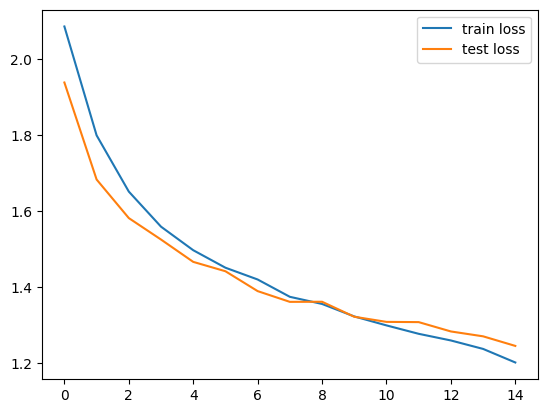

In [10]:
print("Train accuracy:", compute_accuracy(model, train_loader, device))
print("Test accuracy:", compute_accuracy(model, test_loader, device))

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

[[594  43  63  13  18   3  23   8 186  49]
 [ 31 689  12  10   4   3  11  11  79 150]
 [ 71  18 452  63 123  58  94  56  40  25]
 [ 32  27 101 338  75 170 131  43  28  55]
 [ 38  14 166  46 426  51 122  83  45   9]
 [  8   8 117 178  64 415  76  80  27  27]
 [  7  22  67  44  78  24 696  15  16  31]
 [ 28  19  55  61  76  52  30 590  19  70]
 [ 80  64  23   9   9   5   8   5 746  51]
 [ 43 183  14  16   6   6  20  25  72 615]]
Confusion matrix, without normalization


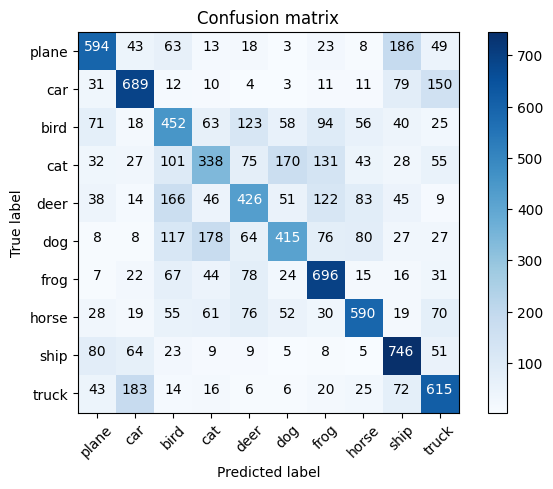

In [11]:
# get all predictions in an array and plot confusion matrix
confusion_matrix = get_confusion_matrix(test_loader, model, device)
print(confusion_matrix)

plot_confusion_matrix(confusion_matrix, [
    "plane", "car", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
])

In [12]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 15, 15]             896
            Conv2d-2             [-1, 64, 7, 7]          18,496
            Conv2d-3            [-1, 128, 3, 3]          73,856
            Linear-4                 [-1, 1024]       1,180,672
            Linear-5                   [-1, 10]          10,250
Total params: 1,284,170
Trainable params: 1,284,170
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 4.90
Estimated Total Size (MB): 5.01
----------------------------------------------------------------
